In [16]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
import csv
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K
import pylab
import scipy.stats

seed = 221
np.random.seed(221)

SMOOTHING_LEN = 15

# see how i loop through train folder below in read_dataset
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

# test_arr = ["./../Datasets/Regular/CS224NWinter2017dataset.csv"]
#"./../Datasets/Regular/CS107Spring2017dataset.csv", "./../Datasets/Regular/CS229Autumn2018dataset.csv",  
#"./../Datasets/Regular/CS110Spring2018dataset.csv", \

# best: spring 2017
"""
LOSS Accuracies
MSE: 69.879
MAE: 62.643
Huber_0.1: 62.636
Huber_1: 62.607
Huber_10: 62.869
Huber_100: 68.836
DYY_Huber_0.3: 58.194
DYY_Huber_1: 58.01
DYY_Huber_10: 52.035
DYY_Huber_20: 52.669
DYY_Huber_30: 49.587
DYY_Huber_32: 47.03
DYY_Huber_40: 51.458
DYY_Huber_100: 65.448

"""


def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,43]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

# 32 original
"""
20 - 54.2
22 - 54.67
15 - 56.2
18: 53.8
19: 54.3
"""

def sqHuber(yHat, y, delta=np.log(32)):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=31, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=keras.losses.mean_absolute_error, optimizer='adam', metrics=['mse'])

    return model

def smooth(x,window_len=11,window='hanning'):


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='full')
    return y[:x.shape[0]]



if __name__ == "__main__":

    valid_seen = []
    k = 8
    valid_metrics = []
    train_metrics = []
    for k_iter in range(k):
        valid_arr = ""
        while True:
            random.shuffle(datasets)
            valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
            if valid_arr not in valid_seen: break
            datasets.append(valid_arr)
        print(valid_arr)
        valid_seen.append(valid_arr)
        X_train, y_train = read_dataset(datasets)
        X_test, y_test = read_dataset_test([valid_arr])
        y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
#         y_test_smooth, X_test = y_test_smooth[:750], X_test[:750,:]

        #X_test, y_test = read_dataset(test_arr)
#         y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]

        # plt.plot(y_train, label = 'Load Influx Without Smoothing')
        # plt.plot(y_train_smooth, label='Load Influx, with smoothing')
        # pylab.legend(loc='upper left')
        # plt.show()

        # normalizes input
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # creates model
        model = create_model()

        # trains model
        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                              verbose=1, mode='auto')
        history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

        # evaluates model
        score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
        yhat = model.predict(X_test_scaled)

        plt.plot(np.exp(y_test_smooth), label = 'Ground Truth')
        plt.plot(np.exp(yhat), label='Predictions')
        pylab.legend(loc='upper left')
        #plt.savefig("./../output/MAE_TA_log/predsvlabels{}.png".format(k_iter))
        plt.show()

        rmse = np.sqrt(mean_squared_error(np.exp(yhat), np.exp(y_test_smooth)))
        print('Validation RMSE: %.3f' % rmse)
        datasets.append(valid_arr)
        valid_metrics.append(rmse)
        train_metrics.append(history.history['loss'][-1])
        
    print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
    print("Valid sets: ", valid_seen)
    print("Mean training error: {}".format(np.mean(np.array(train_metrics))))
    #     np.save("./../output/actualCS224NWinter2017dataset.csv.npy", yhat)
    # print('Test loss:', score[0])
    # print('load influx diff:', np.sqrt(score[0]))

#     # Plots training loss
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
#     plt.show()

#     plt.plot(yhat, c='red')
#     plt.plot(y_test)
#     plt.show()

# 1. no dropout, 15, 8, 3, 1: 9553, 11504
# 2. no dropout, 15, 8, 1: 9413, 11428 --> so far best
# 2b. with dropout: 12259, 14018 --> nice graph.
# 2c. with batchnorm: 7375, 15611
# 3. no dropout, 15, 4, 1: 9683, 11778

./../Datasets/Regular/CS107Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Param

KeyboardInterrupt: 

./../Datasets/Regular/CS110Autumn2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Param

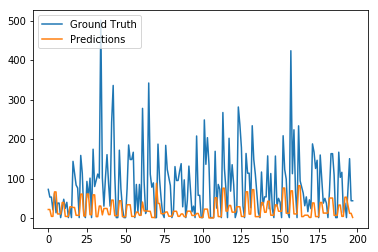

Validation RMSE: 99.331
./../Datasets/Regular/CS107Winter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

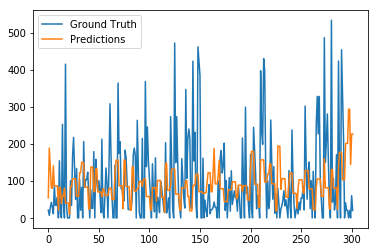

Validation RMSE: 113.190
./../Datasets/Regular/CS224NWinter2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Outpu

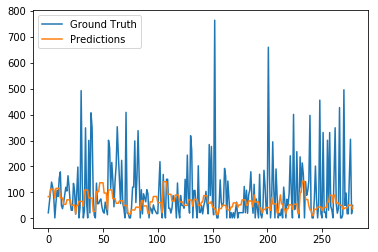

Validation RMSE: 122.676
./../Datasets/Regular/CS107Spring2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

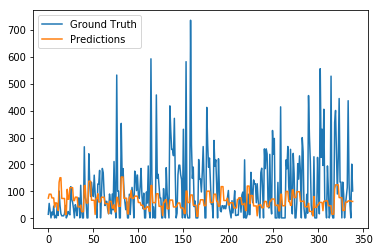

Validation RMSE: 124.474
./../Datasets/Regular/CS124Winter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

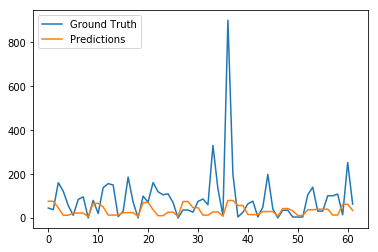

Validation RMSE: 131.981
./../Datasets/Regular/CS161Spring2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

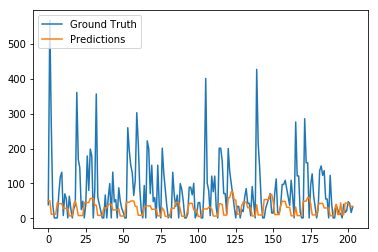

Validation RMSE: 97.220
./../Datasets/Regular/CS107Autumn2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

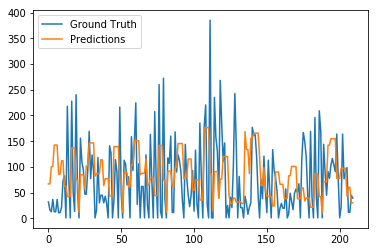

Validation RMSE: 77.083
./../Datasets/Regular/CS124Winter2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

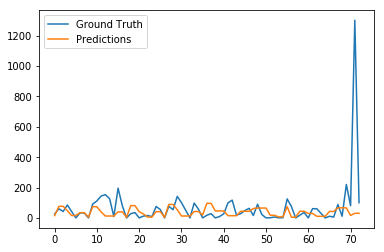

Validation RMSE: 157.510
Leave-one-out RMSEs: [99.33091607928084, 113.19012516775189, 122.67603068996604, 124.47379125943458, 131.98131025045393, 97.21968412330342, 77.08286682465577, 157.50957443523058], mean: 115.43303735375963
Valid sets:  ['./../Datasets/Regular/CS110Autumn2018dataset.csv', './../Datasets/Regular/CS107Winter2018dataset.csv', './../Datasets/Regular/CS224NWinter2017dataset.csv', './../Datasets/Regular/CS107Spring2018dataset.csv', './../Datasets/Regular/CS124Winter2018dataset.csv', './../Datasets/Regular/CS161Spring2017dataset.csv', './../Datasets/Regular/CS107Autumn2018dataset.csv', './../Datasets/Regular/CS124Winter2017dataset.csv']
Mean training error: 0.9089821506853386


In [2]:
# Huber_log
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,43]
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=np.log(32)):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=Huber, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
    y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
#         y_test_smooth, X_test = y_test_smooth[:750], X_test[:750,:]

    #X_test, y_test = read_dataset(test_arr)
#         y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]

    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(np.exp(y_test_smooth), label = 'Ground Truth')
    plt.plot(np.exp(yhat), label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/Huber_log/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(np.exp(yhat), np.exp(y_test_smooth)))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


./../Datasets/Regular/CS224NWinter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Para

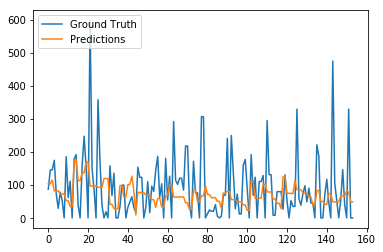

Validation RMSE: 98.990
./../Datasets/Regular/CS107Winter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

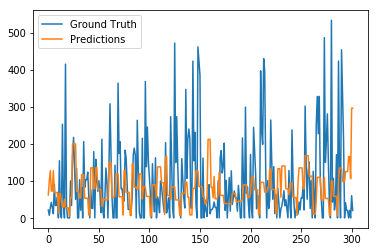

Validation RMSE: 116.109
./../Datasets/Regular/CS221Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

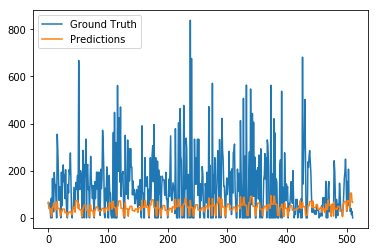

Validation RMSE: 151.348
./../Datasets/Regular/CS221Autumn2016dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

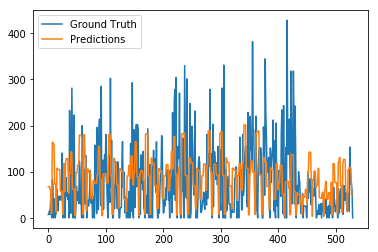

Validation RMSE: 75.003
./../Datasets/Regular/CS224NWinter2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

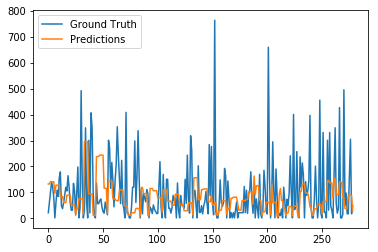

Validation RMSE: 125.231
./../Datasets/Regular/CS161Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

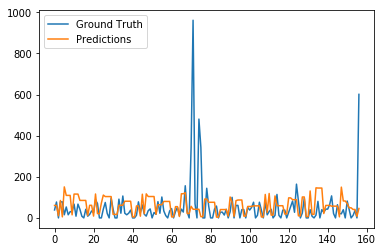

Validation RMSE: 111.668
./../Datasets/Regular/CS124Winter2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

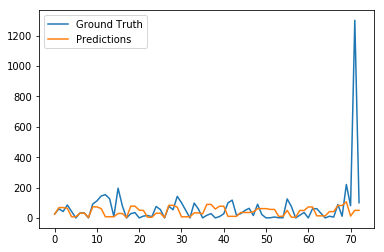

Validation RMSE: 155.786
./../Datasets/Regular/CS124Winter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

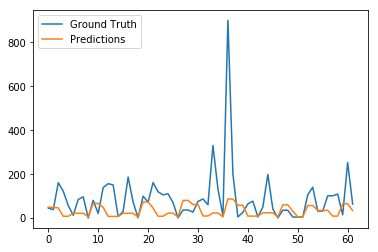

Validation RMSE: 131.915
Leave-one-out RMSEs: [98.98975138213713, 116.10930000274627, 151.3475906579173, 75.0031833201826, 125.2312493271551, 111.66760208012741, 155.78564816504712, 131.91482475931622], mean: 120.75614371182866
Valid sets:  ['./../Datasets/Regular/CS224NWinter2018dataset.csv', './../Datasets/Regular/CS107Winter2018dataset.csv', './../Datasets/Regular/CS221Autumn2017dataset.csv', './../Datasets/Regular/CS221Autumn2016dataset.csv', './../Datasets/Regular/CS224NWinter2017dataset.csv', './../Datasets/Regular/CS161Autumn2017dataset.csv', './../Datasets/Regular/CS124Winter2017dataset.csv', './../Datasets/Regular/CS124Winter2018dataset.csv']
Mean training error: 1.3651488774974663


In [3]:
# sqHuber_log
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,43]
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=np.log(32)):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
    y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
#         y_test_smooth, X_test = y_test_smooth[:750], X_test[:750,:]

    #X_test, y_test = read_dataset(test_arr)
#         y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]

    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(np.exp(y_test_smooth), label = 'Ground Truth')
    plt.plot(np.exp(yhat), label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/sqHuber_log/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(np.exp(yhat), np.exp(y_test_smooth)))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


./../Datasets/Regular/CS224NWinter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Para

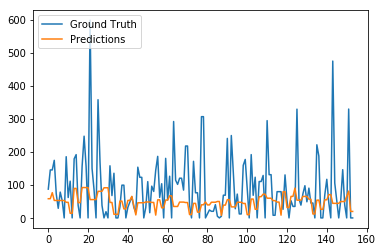

Validation RMSE: 103.880
./../Datasets/Regular/CS221Autumn2016dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

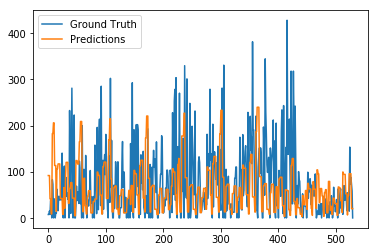

Validation RMSE: 80.031
./../Datasets/Regular/CS107Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

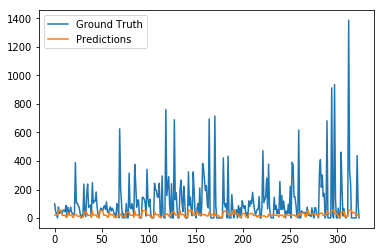

Validation RMSE: 181.805
./../Datasets/Regular/CS107Spring2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

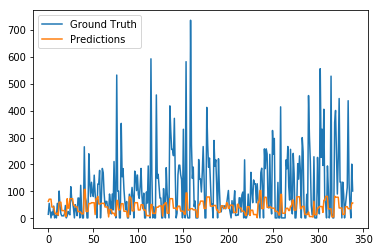

Validation RMSE: 134.061
./../Datasets/Regular/CS107Autumn2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

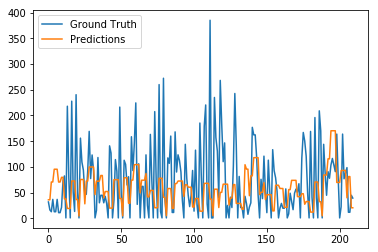

Validation RMSE: 74.664
./../Datasets/Regular/CS224NWinter2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

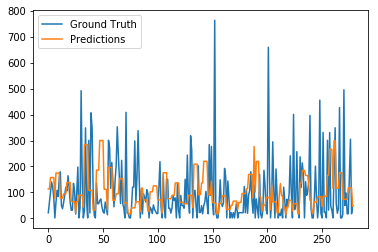

Validation RMSE: 126.884
./../Datasets/Regular/CS161Spring2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

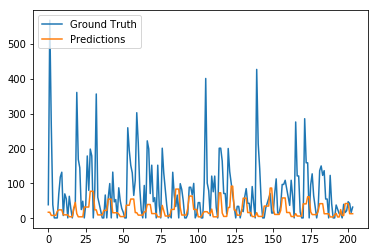

Validation RMSE: 100.988
./../Datasets/Regular/CS161Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

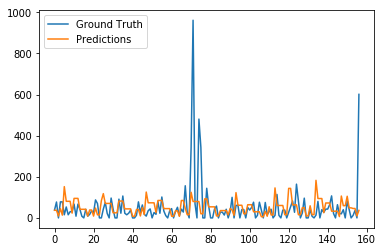

Validation RMSE: 104.758
Leave-one-out RMSEs: [103.8804115268814, 80.030695842395, 181.8048472162278, 134.06073636718, 74.66369345818806, 126.88422923807157, 100.98849875227705, 104.75821555544921], mean: 113.38391599458376
Valid sets:  ['./../Datasets/Regular/CS224NWinter2018dataset.csv', './../Datasets/Regular/CS221Autumn2016dataset.csv', './../Datasets/Regular/CS107Autumn2017dataset.csv', './../Datasets/Regular/CS107Spring2018dataset.csv', './../Datasets/Regular/CS107Autumn2018dataset.csv', './../Datasets/Regular/CS224NWinter2017dataset.csv', './../Datasets/Regular/CS161Spring2017dataset.csv', './../Datasets/Regular/CS161Autumn2017dataset.csv']
Mean training error: 2.942184562691021


In [4]:
# MSE_log
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,43]
        toRemove = [0, 1, 2, 3,4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=np.log(32)):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
    y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
#         y_test_smooth, X_test = y_test_smooth[:750], X_test[:750,:]

    #X_test, y_test = read_dataset(test_arr)
#         y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]

    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(np.exp(y_test_smooth), label = 'Ground Truth')
    plt.plot(np.exp(yhat), label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/MSE_log/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(np.exp(yhat), np.exp(y_test_smooth)))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


./../Datasets/Regular/CS224NWinter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Para

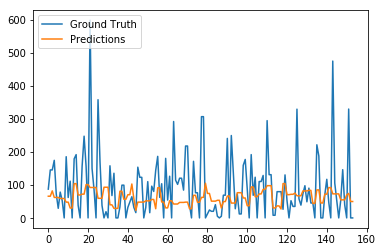

Validation RMSE: 99.760
./../Datasets/Regular/CS107Winter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

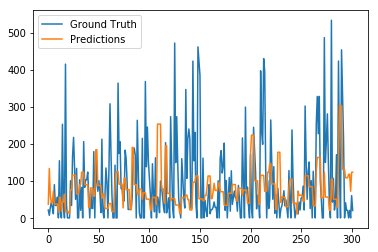

Validation RMSE: 113.913
./../Datasets/Regular/CS224NWinter2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Outpu

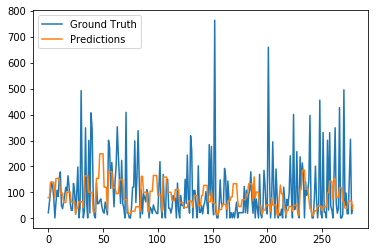

Validation RMSE: 123.563
./../Datasets/Regular/CS107Autumn2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

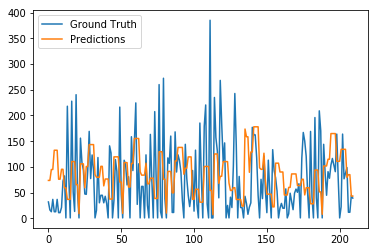

Validation RMSE: 75.596
./../Datasets/Regular/CS221Autumn2016dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

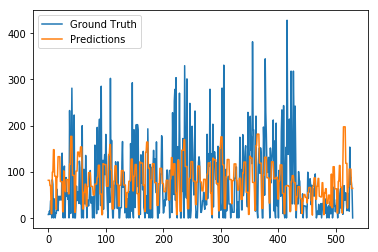

Validation RMSE: 72.469
./../Datasets/Regular/CS107Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

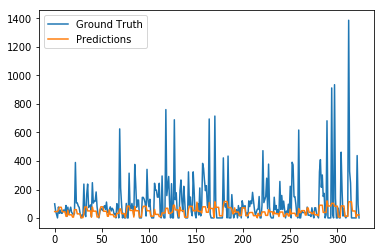

Validation RMSE: 167.599
./../Datasets/Regular/CS110Autumn2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

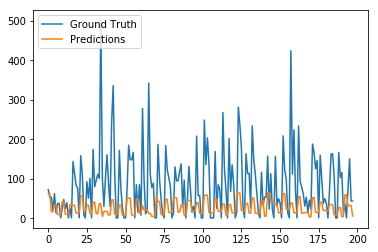

Validation RMSE: 96.724
./../Datasets/Regular/CS124Winter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

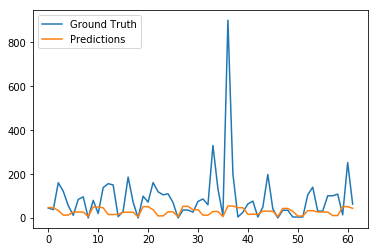

Validation RMSE: 134.911
Leave-one-out RMSEs: [99.75966498163706, 113.91333900370147, 123.56274182571485, 75.5961103288939, 72.46884884084713, 167.5985805017611, 96.72449368977462, 134.91126199859144], mean: 110.5668801463652
Valid sets:  ['./../Datasets/Regular/CS224NWinter2018dataset.csv', './../Datasets/Regular/CS107Winter2018dataset.csv', './../Datasets/Regular/CS224NWinter2017dataset.csv', './../Datasets/Regular/CS107Autumn2018dataset.csv', './../Datasets/Regular/CS221Autumn2016dataset.csv', './../Datasets/Regular/CS107Autumn2017dataset.csv', './../Datasets/Regular/CS110Autumn2018dataset.csv', './../Datasets/Regular/CS124Winter2018dataset.csv']
Mean training error: 1.298008601771751


In [5]:
# MAE_log
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=np.log(32)):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=keras.losses.mean_absolute_error, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
    y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
#         y_test_smooth, X_test = y_test_smooth[:750], X_test[:750,:]

    #X_test, y_test = read_dataset(test_arr)
#         y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]

    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(np.exp(y_test_smooth), label = 'Ground Truth')
    plt.plot(np.exp(yhat), label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/MAE_log/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(np.exp(yhat), np.exp(y_test_smooth)))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


./../Datasets/Regular/CS224NWinter2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Para

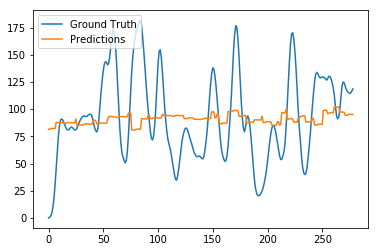

Validation RMSE: 39.735
./../Datasets/Regular/CS161Spring2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

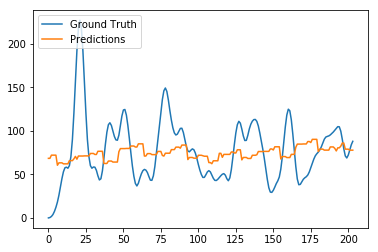

Validation RMSE: 38.606
./../Datasets/Regular/CS224NWinter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

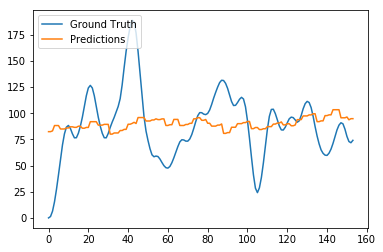

Validation RMSE: 33.286
./../Datasets/Regular/CS161Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

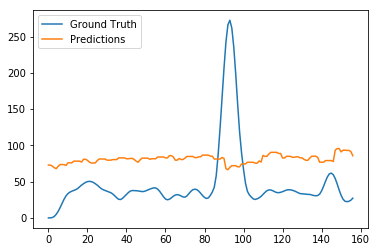

Validation RMSE: 59.841
./../Datasets/Regular/CS110Autumn2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

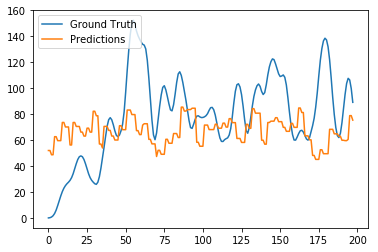

Validation RMSE: 35.781
./../Datasets/Regular/CS107Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

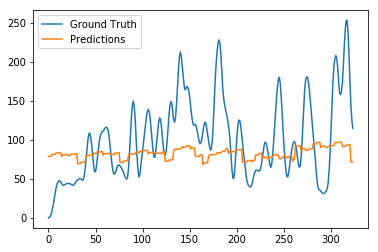

Validation RMSE: 52.604
./../Datasets/Regular/CS107Spring2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

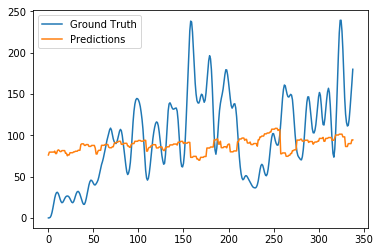

Validation RMSE: 52.861
./../Datasets/Regular/CS107Winter2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

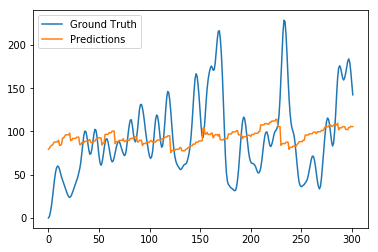

Validation RMSE: 45.557
Leave-one-out RMSEs: [39.73491632939295, 38.60568520396138, 33.28577567236616, 59.840521036606944, 35.78062720303873, 52.60405635167292, 52.8612918725699, 45.55667969243659], mean: 44.7836941702557
Valid sets:  ['./../Datasets/Regular/CS224NWinter2017dataset.csv', './../Datasets/Regular/CS161Spring2017dataset.csv', './../Datasets/Regular/CS224NWinter2018dataset.csv', './../Datasets/Regular/CS161Autumn2017dataset.csv', './../Datasets/Regular/CS110Autumn2018dataset.csv', './../Datasets/Regular/CS107Autumn2017dataset.csv', './../Datasets/Regular/CS107Spring2018dataset.csv', './../Datasets/Regular/CS107Winter2018dataset.csv']
Mean training error: 35.422689668853124


In [7]:
# Huber_smooth
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=Huber, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = smooth(y_train.reshape((-1)),SMOOTHING_LEN)[:len(y_train)]
    y_test_smooth = smooth(y_test.reshape((-1)),SMOOTHING_LEN)[:len(y_test)]
#     y_test_smooth = y_test

    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/Huber_smooth/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


In [8]:
#sqHuber_smooth
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]
    y_test_smooth = smooth(y_test.reshape((-1)),SMOOTHING_LEN)[:len(y_test)]
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/sqHuber_smooth/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


./../Datasets/Regular/CS107Spring2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Param

ValueError: Input arrays should have the same number of samples as target arrays. Found 3004 input samples and 3041 target samples.

In [9]:
#MSE_smooth
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]
    y_test_smooth = smooth(y_test.reshape((-1)),SMOOTHING_LEN)[:len(y_test)]
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/MSE_smooth/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


./../Datasets/Regular/CS224NWinter2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Para

ValueError: Input arrays should have the same number of samples as target arrays. Found 3064 input samples and 3041 target samples.

In [ ]:
#MAE_smooth
# Huber_smooth
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=keras.losses.mean_absolute_error, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]
    y_test_smooth = smooth(y_test.reshape((-1)),SMOOTHING_LEN)[:len(y_test)]
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/MAE_smooth/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


In [10]:
# Huber_TA_smooth
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,43]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=31, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=Huber, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]
    y_test_smooth = smooth(y_test.reshape((-1)),SMOOTHING_LEN)[:len(y_test)]
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/Huber_TA_smooth/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


./../Datasets/Regular/CS221Autumn2016dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Param

ValueError: Input arrays should have the same number of samples as target arrays. Found 2813 input samples and 3041 target samples.

In [11]:
# sqHuber_TA_smooth
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,43]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=31, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]
    y_test_smooth = smooth(y_test.reshape((-1)),SMOOTHING_LEN)[:len(y_test)]
#No smoothing for test set
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/sqHuber_TA_smooth/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


./../Datasets/Regular/CS107Autumn2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Param

ValueError: Input arrays should have the same number of samples as target arrays. Found 3133 input samples and 3041 target samples.

In [ ]:
# MSE_TA_smooth
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,43]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=31, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]
    y_test_smooth = smooth(y_test.reshape((-1)),SMOOTHING_LEN)[:len(y_test)]
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/MSE_TA_smooth/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


In [ ]:
# MAE_TA_smooth
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
#         toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,43]
        toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=31, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=keras.losses.mean_absolute_error, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = smooth(y_train_smooth.reshape((-1)),SMOOTHING_LEN)[:len(y_train_smooth)]
    y_test_smooth = smooth(y_test.reshape((-1)),SMOOTHING_LEN)[:len(y_test)]
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/MAE_TA_smooth/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


In [12]:
def smooth(x,window_len=11,window='hanning'):


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='full')
    return y[:x.shape[0]]

./../Datasets/Regular/CS107Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output Shape              Param

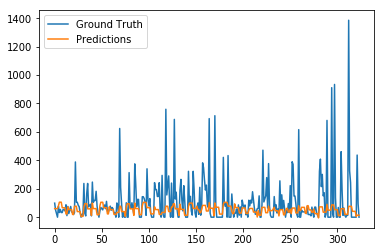

Validation RMSE: 166.760
./../Datasets/Regular/CS107Autumn2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

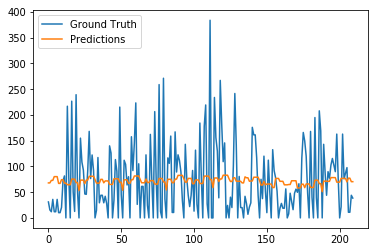

Validation RMSE: 69.555
./../Datasets/Regular/CS110Autumn2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

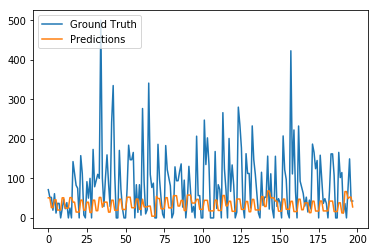

Validation RMSE: 93.476
./../Datasets/Regular/CS107Spring2018dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

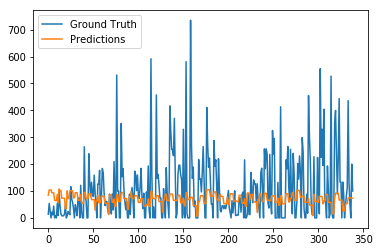

Validation RMSE: 122.192
./../Datasets/Regular/CS224NWinter2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Outpu

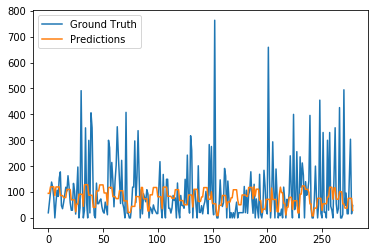

Validation RMSE: 117.540
./../Datasets/Regular/CS161Spring2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output

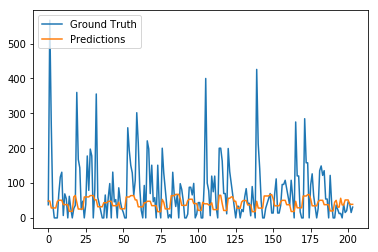

Validation RMSE: 90.835
./../Datasets/Regular/CS161Autumn2017dataset.csv
0 
1 sign_ups
2 serves
3 servers
4 average_wait_time
5 average_serve_time
6 day
7 avgDayServeTime
8 loadInflux
9 daysAfterPrevAssnDue
10 daysUntilNextAssnDue
11 daysTilExam
12 weekNum
13 hourOfDay
14 monday
15 tuesday
16 wednesday
17 thursday
18 friday
19 saturday
20 sunday
21 morning
22 noon
23 afternoon
24 evening
25 L10daysAfterPrevAssnDue
26 L5daysAfterPrevAssnDue
27 L3daysAfterPrevAssnDue
28 L1daysAfterPrevAssnDue
29 L10daysUntilNextAssnDue
30 L5daysUntilNextAssnDue
31 L3daysUntilNextAssnDue
32 L1daysUntilNextAssnDue
33 L10daysTilExam
34 L5daysTilExam
35 L3daysTilExam
36 L1daysTilExam
37 isFirstOHWithinLastThreeHour
38 isFirstOHWithinLastSixHour
39 isLastOHWithinNextThreeHour
40 isLastOHWithinNextSixHour
41 NumStudents
42 InstructorRating
43 AvgHrsSpent
44 ProportionFrosh
45 ProportionGrads
46 ProportionPhDs
_________________________________________________________________
Layer (type)                 Output 

In [ ]:
# Huber
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=Huber, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = y_train
    y_test_smooth = y_test
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/Huber/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


In [ ]:
# sqHuber
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = y_train
    y_test_smooth = y_test
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/sqHuber/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


In [ ]:
# MSE
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = y_train
    y_test_smooth = y_test
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/MSE/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))


In [ ]:
# MAE
datasets = ["./../Datasets/Regular/CS107Autumn2017dataset.csv", "./../Datasets/Regular/CS107Autumn2018dataset.csv", \
"./../Datasets/Regular/CS107Spring2018dataset.csv", "./../Datasets/Regular/CS107Winter2018dataset.csv", \
"./../Datasets/Regular/CS161Autumn2017dataset.csv", "./../Datasets/Regular/CS161Spring2017dataset.csv", \
 "./../Datasets/Regular/CS221Autumn2016dataset.csv", \
"./../Datasets/Regular/CS221Autumn2017dataset.csv", "./../Datasets/Regular/CS110Autumn2018dataset.csv",
           "./../Datasets/Regular/CS224NWinter2018dataset.csv","./../Datasets/Regular/CS224NWinter2017dataset.csv",
           "./../Datasets/Regular/CS124Winter2017dataset.csv", "./../Datasets/Regular/CS124Winter2018dataset.csv"]

def read_dataset(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, day, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay, OH
        # add 3 below to exclude num_servers
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]


        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

#         for i, j in enumerate(raw_data[0]):
#             print (i, j)

    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))

    return X, y

def read_dataset_test(arr):
    X, y = [], []
    for q, quarter in enumerate (arr):

        f = open(quarter, 'r')
        reader = csv.reader(f)
        raw_data = [row for row in reader]
        key = {k:v for k, v in enumerate(raw_data[0])}

        # removes 0, sign_ups, serves, servers (3), avg_wait_time, avg_serve_time, avg_day_serve_time, load_influx,
        # daysAfterprevdue, daysUntilNextdue, daysTillExam, hourOfDay
        toRemove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]
#         toRemove = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 37, 38, 39, 40]

        for index in toRemove:
            del key[index]

        for i, d in enumerate(raw_data):
            if i == 0:
                continue	

            load_influx = float(d[8]) 
            y.append(load_influx)
            X.append([float(d[f]) for f in key.keys()])

        for i, j in enumerate(raw_data[0]):
            print (i, j)


    X, y = np.asarray(X), np.asarray(y).reshape((-1, 1))
    return X, y

def sqHuber(yHat, y, delta=32):
    shrug_const = (.5 * delta**2 - (1/np.sqrt(2)) * delta)
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , K.sqrt(delta*(K.abs(y-yHat)-0.5*delta)) + shrug_const)

def Huber(yHat, y, delta=1):
    return K.tf.where(K.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(K.abs(y-yHat)-0.5*delta))
# def Gaussian(yHat, y):
    
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=30, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    # adam = optimizers.Adam(lr=0.001, decay=0.01)
#     model.compile(loss=sqHuber, optimizer='adam', metrics=['mse'])
    model.compile(loss=keras.losses.mean_absolute_error, optimizer='adam', metrics=['mse'])

    return model

valid_seen = []
k = 8
valid_metrics = []
train_metrics = []
for k_iter in range(k):
    valid_arr = ""
    while True:
        random.shuffle(datasets)
        valid_arr = datasets.pop()
#             valid_arr = "./../Datasets/Regular/CS107Spring2017dataset.csv"
#             datasets.remove("./../Datasets/Regular/CS107Spring2017dataset.csv")
        if valid_arr not in valid_seen: break
        datasets.append(valid_arr)
    print(valid_arr)
    valid_seen.append(valid_arr)
    X_train, y_train = read_dataset(datasets)
    X_test, y_test = read_dataset_test([valid_arr])
#     y_train_smooth, y_test_smooth = np.log(y_train + 1), np.log(y_test + 1)
    
    #X_test, y_test = read_dataset(test_arr)
    y_train_smooth = y_train
    y_test_smooth = y_test
    # normalizes input
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # creates model
    model = create_model()

    # trains model
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
    history = model.fit(X_train_scaled, y_train_smooth, epochs=1000, batch_size=64, callbacks = [earlystop], verbose=0, validation_split=0.05)

    # evaluates model
    score = model.evaluate(X_test_scaled, y_test_smooth, verbose=0)
    yhat = model.predict(X_test_scaled)

    plt.plot(y_test_smooth, label = 'Ground Truth')
    plt.plot(yhat, label='Predictions')
    pylab.legend(loc='upper left')
    #plt.savefig("./../output/MAE/predsvlabels{}.png".format(k_iter))
    plt.show()

    rmse = np.sqrt(mean_squared_error(yhat, y_test_smooth))
    print('Validation RMSE: %.3f' % rmse)
    datasets.append(valid_arr)
    valid_metrics.append(rmse)
    train_metrics.append(history.history['loss'][-1])

print("Leave-one-out RMSEs: {}, mean: {}".format(valid_metrics, np.mean(np.array(valid_metrics))))
print("Valid sets: ", valid_seen)
print("Mean training error: {}".format(np.mean(np.array(train_metrics))))
